In [1]:
#importing Libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import LabelEncoder#for encoding
from sklearn.model_selection import train_test_split#for train test splitting
from sklearn.ensemble import RandomForestClassifier

from sklearn.tree import DecisionTreeClassifier#for decision tree object
from sklearn.tree import plot_tree#for visualizing tree
from sklearn import tree
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report
#for checking testing results
 

from sklearn.model_selection import GridSearchCV, KFold , cross_val_score
from sklearn.feature_selection import SelectKBest, chi2

import warnings
warnings.filterwarnings('ignore')


from collections import Counter
from sklearn.metrics import confusion_matrix,accuracy_score, roc_auc_score, roc_curve, precision_recall_curve

In [2]:
#Reading dataset
df = pd.read_csv("Fraud_check.csv")
df

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban
0,NO,Single,68833,50047,10,YES
1,YES,Divorced,33700,134075,18,YES
2,NO,Married,36925,160205,30,YES
3,YES,Single,50190,193264,15,YES
4,NO,Married,81002,27533,28,NO
...,...,...,...,...,...,...
595,YES,Divorced,76340,39492,7,YES
596,YES,Divorced,69967,55369,2,YES
597,NO,Divorced,47334,154058,0,YES
598,YES,Married,98592,180083,17,NO


## EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Undergrad        600 non-null    object
 1   Marital.Status   600 non-null    object
 2   Taxable.Income   600 non-null    int64 
 3   City.Population  600 non-null    int64 
 4   Work.Experience  600 non-null    int64 
 5   Urban            600 non-null    object
dtypes: int64(3), object(3)
memory usage: 28.3+ KB


In [4]:
df.isnull().any()

Undergrad          False
Marital.Status     False
Taxable.Income     False
City.Population    False
Work.Experience    False
Urban              False
dtype: bool

In [5]:
df.shape

(600, 6)

In [6]:
df.describe()

,Taxable.Income,City.Population,Work.Experience
count,600.000000,600.000000,600.000000
mean,55208.375000,108747.368333,15.558333
std,26204.827597,49850.075134,8.842147
min,10003.000000,25779.000000,0.000000
25%,32871.500000,66966.750000,8.000000
50%,55074.500000,106493.500000,15.000000
75%,78611.750000,150114.250000,24.000000
max,99619.000000,199778.000000,30.000000


In [7]:
# Converting taxable_income <= 30000 as "Risky" and others are "Good"
df1=df.copy()
df1['taxable_category'] = pd.cut(x = df1['Taxable.Income'], bins = [10002,30000,99620], labels = ['Risky', 'Good'])
df1.head()

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban,taxable_category
0,NO,Single,68833,50047,10,YES,Good
1,YES,Divorced,33700,134075,18,YES,Good
2,NO,Married,36925,160205,30,YES,Good
3,YES,Single,50190,193264,15,YES,Good
4,NO,Married,81002,27533,28,NO,Good


In [8]:
categorical_features = df.describe(include=["object"]).columns
categorical_features

Index(['Undergrad', 'Marital.Status', 'Urban'], dtype='object')

In [9]:
numerical_features = df.describe(include=["int64"]).columns
numerical_features

Index(['Taxable.Income', 'City.Population', 'Work.Experience'], dtype='object')

##   Data Visualization

#Univariate Analysis

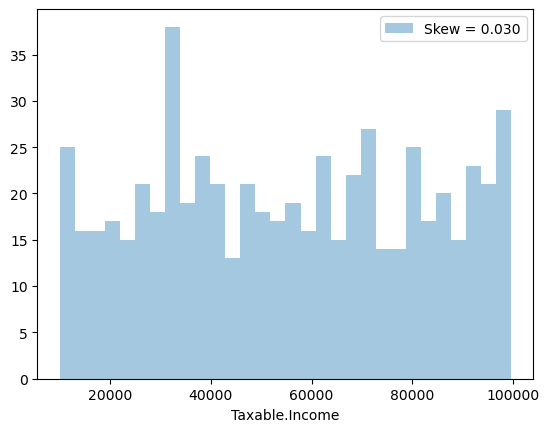

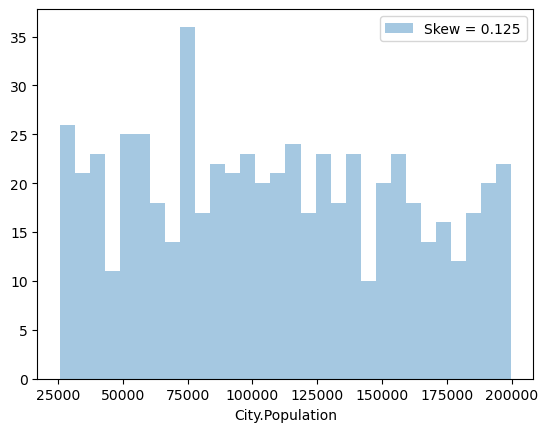

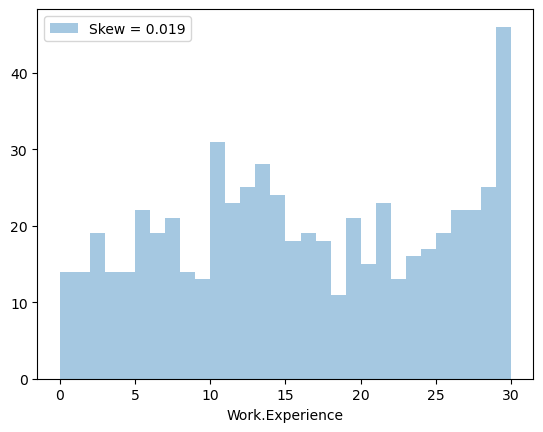

In [10]:
numerical_features=[feature for feature in df.columns if df[feature].dtypes != 'O']
for feat in numerical_features:
    skew = df[feat].skew()
    sns.distplot(df[feat], kde= False, label='Skew = %.3f' %(skew), bins=30)
    plt.legend(loc='best')
    plt.show()

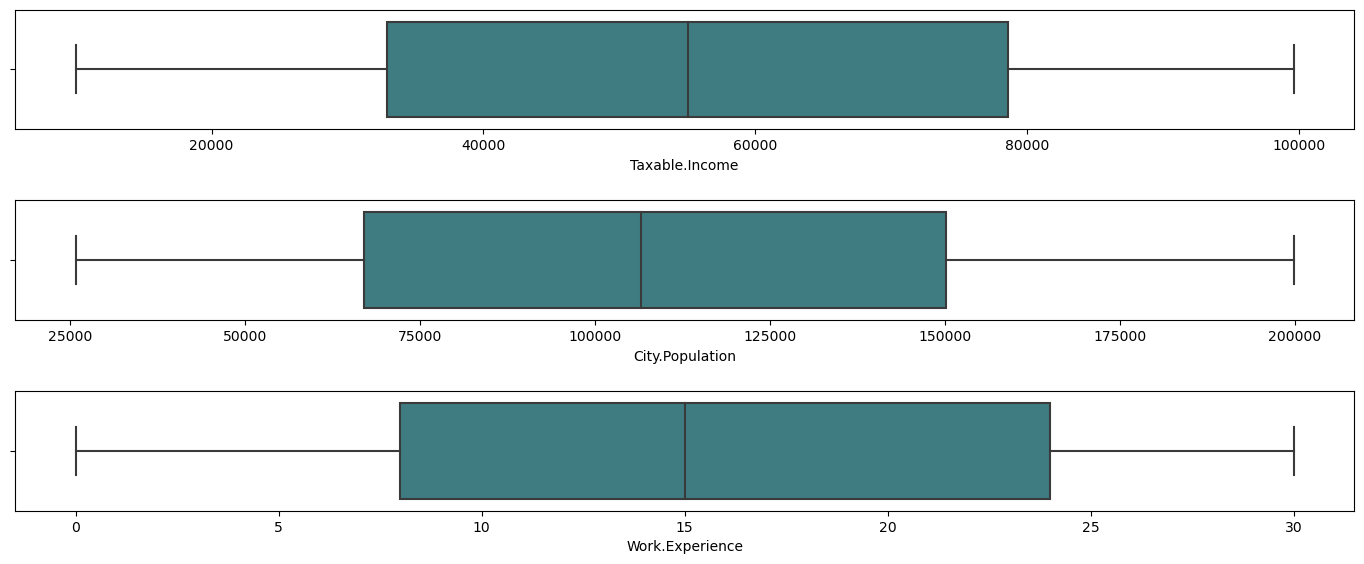

In [11]:
ot=df.copy() 
fig, axes=plt.subplots(3,1,figsize=(14,6),sharex=False,sharey=False)
sns.boxplot(x='Taxable.Income',data=ot,palette='crest',ax=axes[0])
sns.boxplot(x='City.Population',data=ot,palette='crest',ax=axes[1])
sns.boxplot(x='Work.Experience',data=ot,palette='crest',ax=axes[2])
plt.tight_layout(pad=2.0)

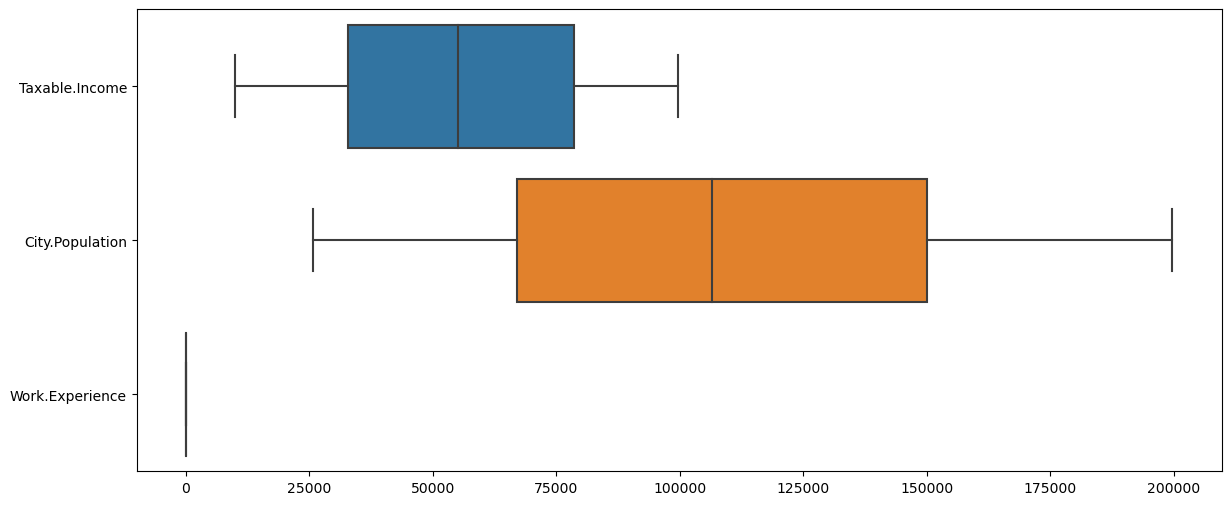

In [12]:
plt.figure(figsize=(14,6))
sns.boxplot(data=df[numerical_features], orient="h");

#Multivariate Analysis

<Figure size 800x800 with 0 Axes>

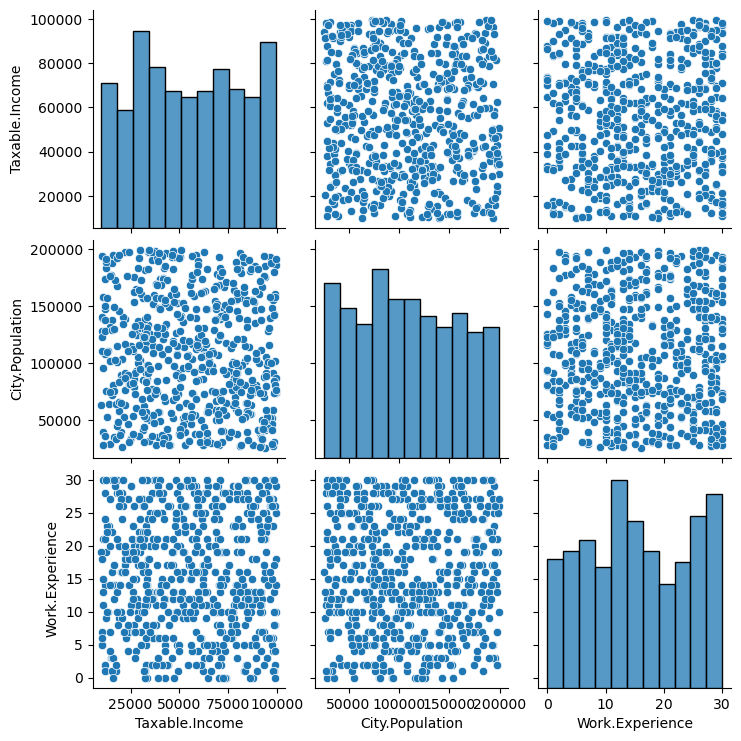

In [13]:
plt.figure(figsize=(8,8))
sns.pairplot(df, palette='coolwarm')
plt.show()

<Axes: >

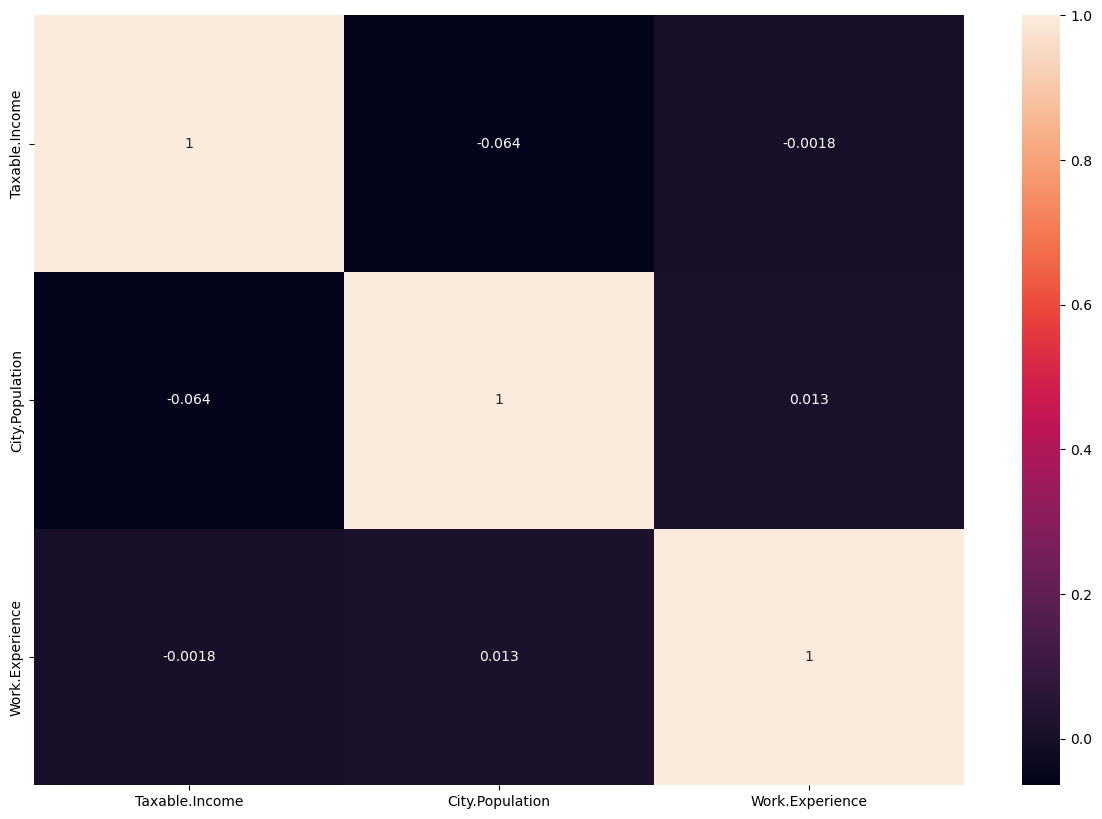

In [14]:
# Havi)ng a look at the correlation matrix

fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(df.corr(), annot=True)

In [15]:
df1.taxable_category.value_counts()

Good     476
Risky    124
Name: taxable_category, dtype: int64

Text(0.5, 1.0, 'Risky or Good for Individual Taxable Income ')

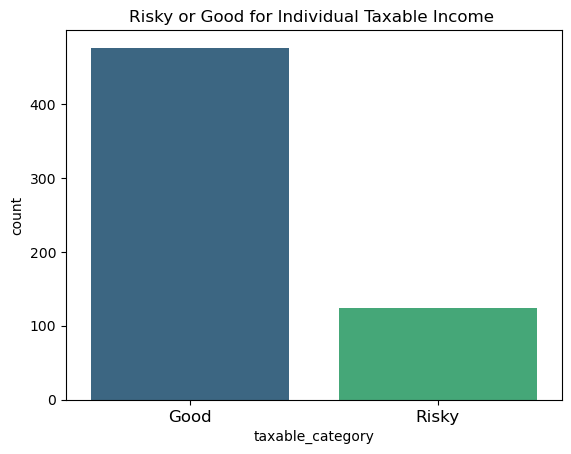

In [16]:
sns.countplot(x='taxable_category', data=df1, palette = 'viridis', 
              order=df1['taxable_category'].value_counts().index)
plt.xticks(fontsize = 12)
plt.title('Risky or Good for Individual Taxable Income ')

## Data Pre-Processing

In [17]:
data = df1.copy()
data.rename(columns={'Marital.Status':'Marital_Status', 'Taxable.Income':'Taxable_Income','Work.Experience':'Work_Experience','City.Population':'City_Population'}, inplace = True)
data.drop('Taxable_Income', axis=1, inplace = True)
categorical_features = data.describe(include=["object",'category']).columns
categorical_features

Index(['Undergrad', 'Marital_Status', 'Urban', 'taxable_category'], dtype='object')

In [18]:
#Creating dummy vairables of the categorical features
le = LabelEncoder()
for col in categorical_features:
        le.fit(data[col])
        data[col] = le.transform(data[col])
data.head()

,Undergrad,Marital_Status,City_Population,Work_Experience,Urban,taxable_category
0,0,2,50047,10,1,0
1,1,0,134075,18,1,0
2,0,1,160205,30,1,0
3,1,2,193264,15,1,0
4,0,1,27533,28,0,0


In [19]:
data.taxable_category.value_counts()

0    476
1    124
Name: taxable_category, dtype: int64

In [20]:
data.head()

,Undergrad,Marital_Status,City_Population,Work_Experience,Urban,taxable_category
0,0,2,50047,10,1,0
1,1,0,134075,18,1,0
2,0,1,160205,30,1,0
3,1,2,193264,15,1,0
4,0,1,27533,28,0,0


## Model building

In [21]:
#Split into input (x) and output (y) variables 

x = data.drop('taxable_category',axis=1)
y = data['taxable_category']

In [22]:
# Splitting data into training and testing data set
x_train, x_test,y_train,y_test = train_test_split(x,y, test_size=0.2,random_state=40)

In [23]:
print("Shape of x_train : ",x_train.shape)
print("Shape of x_test  : ",x_test.shape)
print("Shape of y_train : ",y_train.shape)
print("Shape of y_test  : ",y_test.shape)

Shape of x_train :  (480, 5)
Shape of x_test  :  (120, 5)
Shape of y_train :  (480,)
Shape of y_test  :  (120,)


## Building Random Forest Classifier 

In [24]:
kfold = KFold(n_splits = 10 , random_state = 7 , shuffle =True)


rf = RandomForestClassifier(max_depth=5, min_samples_leaf=3, n_estimators=100,
                       n_jobs=-1, random_state=42)
rf.fit(x_train , y_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=3, n_jobs=-1,
                       random_state=42)

In [25]:
# Use the forest's predict method on the test data
y_pred = rf.predict(x_test)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [26]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7666666666666667
[[92  0]
 [28  0]]
              precision    recall  f1-score   support

           0       0.77      1.00      0.87        92
           1       0.00      0.00      0.00        28

    accuracy                           0.77       120
   macro avg       0.38      0.50      0.43       120
weighted avg       0.59      0.77      0.67       120



In [27]:
results = cross_val_score(rf , x , y , cv = kfold)

In [28]:
print(results.mean())

0.7933333333333332


## Use GridSearch to find optimum Parameters

In [29]:

rf = RandomForestClassifier(random_state=42, n_jobs=-1)

params = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
    'min_samples_leaf': [5, 10, 20, 30],
    'n_estimators': [50, 100, 200, 500],
    'max_features': ["sqrt", "log2"]
}

grid_search = GridSearchCV(estimator=rf, param_grid=params, cv=5, n_jobs=-1, verbose=2, scoring="accuracy")
grid_search.fit(x, y)


Fitting 5 folds for each of 256 candidates, totalling 1280 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [5, 10, 20, 30],
                         'n_estimators': [50, 100, 200, 500]},
             scoring='accuracy', verbose=2)

In [30]:
print(grid_search.best_params_)

{'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 50}


In [31]:
print(grid_search.best_score_)

0.7933333333333332


In [32]:
grid_search.best_estimator_

RandomForestClassifier(max_depth=2, min_samples_leaf=5, n_estimators=50,
                       n_jobs=-1, random_state=42)

## Modelling with optimum parameters from Gridsearchcv

In [37]:
import sklearn.ensemble as ensemble
from sklearn.model_selection import KFold

kfold = KFold(n_splits=10, random_state=7, shuffle=True)
best_rf = ensemble.RandomForestClassifier(
    max_depth=2, 
    max_features="sqrt",
    min_samples_leaf=5,
    n_estimators=50,
    n_jobs=-1,
    random_state=42
)
best_rf.fit(x_train, y_train)


RandomForestClassifier(max_depth=2, min_samples_leaf=5, n_estimators=50,
                       n_jobs=-1, random_state=42)

In [38]:
# Use the forest's predict method on the test data
y_pred1 = best_rf.predict(x_test)
y_pred1

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [39]:
print("Accuracy:", accuracy_score(y_test, y_pred1))
print(confusion_matrix(y_test, y_pred1))
print(classification_report(y_test, y_pred1))

Accuracy: 0.7666666666666667
[[92  0]
 [28  0]]
              precision    recall  f1-score   support

           0       0.77      1.00      0.87        92
           1       0.00      0.00      0.00        28

    accuracy                           0.77       120
   macro avg       0.38      0.50      0.43       120
weighted avg       0.59      0.77      0.67       120



In [40]:
results = cross_val_score(rf , x , y , cv = kfold)
print(results.mean())

0.7466666666666667
